In [1]:
import os
os.chdir('..')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:


import datasets
from utils import *
from kitti_utils import *

from __future__ import absolute_import, division, print_function

from trainer import Trainer
from options import MonodepthOptions
from torch.utils.data import DataLoader
import torch
import PIL.Image as pil

In [3]:
self_opt_dataset='kitti'
datasets_dict = {"kitti": datasets.KITTIRAWDataset,
                 "kitti_odom": datasets.KITTIOdomDataset}

self_dataset = datasets_dict[self_opt_dataset]

# Experimental to reduce data train
self_opt_split = 'mini_data' 
fpath = os.path.join(os.path.abspath(''), "splits", self_opt_split, "{}_files.txt")
train_filenames = readlines(fpath.format("train"))
train_filenames_mini = [x for x in train_filenames if x[0:37]=='2011_09_26/2011_09_26_drive_0022_sync']

In [4]:
self_opt_data_path = 'C:\\Users\\madin\\Documents\\Dataset\\Kitti_raw'

#color = self.loader(self.get_image_path(folder, frame_index, side))
self_opt_height= 192
self_opt_width= 640
len_seq = 5
self_opt_frame_ids= [0, -1,1]
self_opt_scales = [0, 1, 2, 3]
self_opt_batch_size = 12
self_device='cuda'
img_ext = '.png'

# Set Dataset, Dataloader, and test input batch

In [5]:
import datasets

In [6]:
train_dataset = self_dataset(
    self_opt_data_path, train_filenames_mini, self_opt_height, self_opt_width,
    self_opt_frame_ids+list(range(-len_seq+1,min(self_opt_frame_ids))), 4, is_train=True, img_ext=img_ext)
train_loader = DataLoader(
    train_dataset, self_opt_batch_size, True, pin_memory=True, drop_last=True,collate_fn=datasets.seq_collate)
train_loader_raw = DataLoader(
    train_dataset, self_opt_batch_size, True, pin_memory=True, drop_last=True)

In [7]:
batch_idx,inputs=next(enumerate(train_loader))
batch_idx,inputs_raw = next(enumerate(train_loader_raw))

In [8]:
print(type(inputs),type(inputs_raw))
print(len(list(inputs.keys())),len(list(inputs_raw.keys())))
print(inputs["color_aug_seq",0].shape,inputs_raw["color_aug", 0, 0].shape)

<class 'dict'> <class 'dict'>
58 57
torch.Size([12, 5, 3, 192, 640]) torch.Size([12, 3, 192, 640])


Validate input sequence

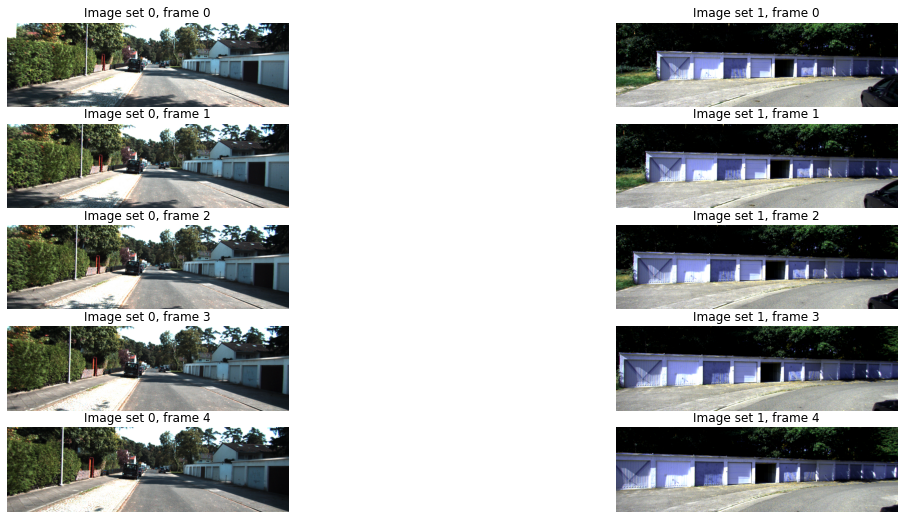

In [9]:
plt.figure (figsize= (20,9)) 
for i in range(2*len_seq):
    plt.subplot(5,2,2*(i%len_seq)+int(i/len_seq)+1)
    image=inputs["color_aug_seq",0][int(i/len_seq)][i%len_seq]
    plt.imshow(image.permute(1,2,0).cpu().numpy())
    plt.title('Image set {0}, frame {1}'.format(int(i/len_seq),i%len_seq))
    plt.axis('off')

# Test Decoder - Encoder

### Load Model

In [10]:
import networks

In [11]:
self_models = {}
self_opt_num_layers=18
self_opt_weights_init = "pretrained"
self_device = 'cuda'
## MODEL ##

self_models["encoder"] = networks.ResnetEncoder(self_opt_num_layers, 
                                                self_opt_weights_init)
self_models["encoder"].to(self_device)

self_models["encoder_ori"] = networks.ResnetEncoderOri(self_opt_num_layers, 
                                                self_opt_weights_init)
self_models["encoder_ori"].to(self_device)

self_models["depth"] = networks.DepthDecoder(
    self_models["encoder"].num_ch_enc, self_opt_scales)
self_models["depth"].to(self_device)

print('Load model done')

Load model done


### Test Resnet Encoder

In [12]:
for key, ipt in inputs.items():
    inputs[key] = ipt.to(self_device)

In [13]:
with torch.no_grad():
    features,last_states = self_models["encoder"](inputs["color_aug_seq", 0])

In [14]:
for i in features:
    print(i.shape)

torch.Size([12, 64, 96, 320])
torch.Size([12, 64, 48, 160])
torch.Size([12, 128, 24, 80])
torch.Size([12, 256, 12, 40])
torch.Size([12, 512, 6, 20])


### Decoding Process

In [15]:
with torch.no_grad():
    outputs = self_models["depth"](features)

In [16]:
print(outputs[("disp", 0)].shape)

torch.Size([12, 1, 192, 640])


In [17]:
image.size(1)

192

In [18]:
disp = outputs[("disp", 0)][0].unsqueeze(0)
original_width = image.size(2)
original_height = image.size(1)
disp_resized = torch.nn.functional.interpolate(
    disp, (original_height, original_width), mode="bilinear", align_corners=False)
disp_resized_np = disp_resized.squeeze().cpu().numpy()

In [19]:
disp_resized_np.shape

(192, 640)

In [20]:
# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)
normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
im = pil.fromarray(colormapped_im)

(-0.5, 639.5, 191.5, -0.5)

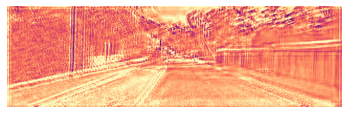

In [21]:
plt.imshow(colormapped_im)
plt.axis('off')